In [1]:
# Install dependencies (if running in a notebook)
!pip install -U datasets transformers fsspec huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.2/484.2 kB 27.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.31.1
    Uninstalling huggingface-hub-0.31.1:
      Successfully uninstalled huggingface-hub-0.31.1
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_sy

In [2]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import Hugging Face modules
from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    GPT2LMHeadModel,
    GPT2Config
)
# Import the original GPT-2 block definition to subclass it
from transformers.models.gpt2.modeling_gpt2 import GPT2Block

import time
import os
import psutil

In [23]:
# ------------------------------
# Hyperparameters and settings
# ------------------------------

MODEL_NAME = "gpt2"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 2
LR = 6e-5
MAX_SEQ_LENGTH = 128       # maximum sequence length for training examples
NUM_EPOCHS = 10            # For demonstration we use few epochs
GRAD_CLIP = 1.0
L1_COEFF = 0               # Coefficient for L1 penalty on attention mask weights (0 for no impact)

print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# -------------------------------------------
# 1. Custom Attention Module: Learnable Weighted Combination of Candidate Masks
# -------------------------------------------

class CustomLearnableAttention(nn.Module):
    """
    This custom attention module uses the standard Q, K, V projections
    but instead of using a fixed attention mask (or a fixed sliding window),
    it computes several candidate binary masks and then forms a weighted combination
    of them. The weights are learnable parameters (passed through a sigmoid) and
    an L1 penalty will be applied to encourage sparsity (i.e. use as few tokens as possible).

    Candidate masks defined:
      - Candidate 0: Only attend to the last 5 tokens.
      - Candidate 1: Only attend to the last 10 tokens.
      - Candidate 2: Full causal (all tokens up to the current one).
    """
    def __init__(self, d_model, num_heads, num_candidates=5):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads
        self.num_candidates = num_candidates

        # Linear projection layers for queries, keys, and values
        self.query_proj = nn.Linear(d_model, d_model)
        self.key_proj = nn.Linear(d_model, d_model)
        self.value_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # Learnable coefficients for each candidate mask
        init_alpha = torch.zeros(num_candidates)
        self.alpha = nn.Parameter(init_alpha)  # shape: (num_candidates,)

        self.candidate_masks = CustomLearnableAttention.get_candidate_masks(MAX_SEQ_LENGTH, device=DEVICE)
        self.cached_seq_length = MAX_SEQ_LENGTH

    def forward(self, hidden_states, attention_mask=None, **kwargs):
        batch_size, seq_length, _ = hidden_states.size()
        device = hidden_states.device

        # Project hidden states to Q, K, V
        q = self.query_proj(hidden_states)  # shape: (B, L, d_model)
        k = self.key_proj(hidden_states)
        v = self.value_proj(hidden_states)

        # Reshape into multiple heads: (B, num_heads, L, head_dim)
        q = q.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute raw attention scores
        scaling_factor = self.head_dim ** 0.5
        scores = torch.matmul(q, k.transpose(-2, -1)) / scaling_factor  # shape: (B, num_heads, L, L)

        # Apply any provided attention mask (e.g. for padding)
        if attention_mask is not None:
            # If the mask is of shape (B, L), expand it to (B, 1, 1, L)
            if attention_mask.dim() == 2:
                extended_attention_mask = attention_mask[:, None, None, :]
            # If it already has 4 dimensions (B, 1, L, L) or similar, use it as is
            elif attention_mask.dim() == 4:
                extended_attention_mask = attention_mask
            else:
                raise ValueError("Unexpected attention_mask dimensions: " + str(attention_mask.shape))
            scores = scores.masked_fill(extended_attention_mask == 0, -1e9)


        # -----------------------------------------------
        # Compute the weighted learnable attention mask
        # -----------------------------------------------
        # 1) Compute candidate masks based on the current sequence length
        candidate_masks = self.candidate_masks if seq_length == self.cached_seq_length else CustomLearnableAttention.get_candidate_masks(seq_length, device=device) # shape: (num_candidates, L, L)

        # 2) Add two new dimensions so that we can combine with the batch and head dims.
        candidate_masks = candidate_masks.unsqueeze(0).unsqueeze(0)  # shape: (1, 1, num_candidates, L, L)

        # 3) Compute learnable weights from self.alpha (use sigmoid to constrain each weight to [0,1])
        w = torch.sigmoid(self.alpha)  # shape: (num_candidates,)

        # Reshape weights for broadcasting: (1, 1, num_candidates, 1, 1)
        w = w.view(1, 1, self.num_candidates, 1, 1)

        # 4) Form the weighted sum over candidate masks
        final_mask = torch.sum(w * candidate_masks, dim=2)  # shape: (1, 1, L, L)

        # Expand final_mask over batch and heads.
        final_mask = final_mask.expand(batch_size, self.num_heads, seq_length, seq_length)

        # -------------------------------------------------
        # Now compute the final attention probabilities
        # First, get the standard softmax attention probabilities
        attn_probs = F.softmax(scores, dim=-1)  # shape: (B, num_heads, L, L)

        # Multiply elementwise by learnable mask
        attn_probs = attn_probs * final_mask
        # Renormalize over the key dimension
        attn_probs = attn_probs / (attn_probs.sum(dim=-1, keepdim=True) + 1e-8)

        # Compute the context as the weighted sum of the values
        context = torch.matmul(attn_probs, v)  # shape: (B, num_heads, L, head_dim)

        # Recombine heads
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        output = self.out_proj(context)
        return output

    # Return custom candidate attention masks. Currently returns 5 masks where the i'th mask
    # contains all 0s except for the i'th to last token in each row.
    @staticmethod
    def get_candidate_masks(seq_length, device, num_candidates=5):
        # Create a tensor for row indices: shape (seq_length,)
        rows = torch.arange(seq_length, device=device)
        # Create a tensor for candidate offsets: shape (num_candidates, 1)
        candidates = torch.arange(num_candidates, device=device).unsqueeze(1)

        # Compute the column indices for each candidate mask:
        # For candidate n and row i, desired column = i - n
        cols = rows.unsqueeze(0) - candidates  # shape: (num_candidates, seq_length)

        # Prepare empty mask tensor of shape (num_candidates, seq_length, seq_length)
        masks = torch.zeros(num_candidates, seq_length, seq_length, device=device)

        # Create a corresponding tensor of row indices for each candidate:
        row_idx = rows.unsqueeze(0).expand(num_candidates, seq_length)  # shape: (num_candidates, seq_length)

        # For indexing purposes, also create an index for the candidate dimension:
        candidate_idx = torch.arange(num_candidates, device=device).unsqueeze(1).expand(num_candidates, seq_length)

        # Only assign 1.0 where the computed column index is valid (>= 0)
        valid = cols >= 0
        masks[candidate_idx[valid], row_idx[valid], cols[valid]] = 1.0

        return masks

        # ----- ALTERNATE UNUSED MASKS -----
        # # First token
        # mask_first_token = torch.zeros(seq_length, seq_length, device=device)
        # for i in range(seq_length):
        #     mask_first_token[i, 0] = 1.0
        # masks.append(mask_first_token)

        # # Last 5 tokens
        # mask_last_5 = torch.zeros(seq_length, seq_length, device=device)
        # for i in range(seq_length):
        #     start = max(0, i - 4)  # allow up to 5 tokens (including current)
        #     mask_last_5[i, start:i+1] = 1.0

        # # Last 10 tokens
        # mask_last_10 = torch.zeros(seq_length, seq_length, device=device)
        # for i in range(seq_length):
        #     start = max(0, i - 9)
        #     mask_last_10[i, start:i+1] = 1.0

        # # Full causal mask
        # causal_mask = torch.tril(torch.ones(seq_length, seq_length, device=device))
        # masks.append(causal_mask)

        # # First 5 tokens
        # mask_first_5 = torch.zeros(seq_length, seq_length, device=device)
        # for i in range(seq_length):
        #     end = min(4, i)
        #     mask_first_5[i, 0:end+1] = 1.0

        # Every other
        # mask_every_other = torch.zeros(seq_length, seq_length, device=device)
        # for i in range(seq_length):
        #     mask_every_other[i, i::2] = 1.0
        # ----------------------------------

In [5]:
# -------------------------------------------
# 3. Custom GPT-2 Block with our CustomLearnableAttention
# -------------------------------------------

class CustomGPT2Block(GPT2Block):
    """
    Subclass the original GPT2Block to replace the attention layer with our custom one.
    We also copy the original Q, K, V, and output projection weights so that the custom
    attention begins with a similar behavior to the baseline.
    """
    def __init__(self, config):
        super().__init__(config)
        # Replace the default attention with our custom attention
        self.attn = self._create_custom_attention(config)

    def _create_custom_attention(self, config):
        # Instantiate our custom attention module.
        custom_attn = CustomLearnableAttention(config.n_embd, config.n_head)
        original_attn = self.attn  # the original GPT2Attention layer

        # The original attention concatenates Q, K, V in a single linear layer
        # We split the weights from the original model and copy them into our projections
        q_w, k_w, v_w = original_attn.c_attn.weight.chunk(3, dim=1)
        q_b, k_b, v_b = original_attn.c_attn.bias.chunk(3, dim=0)
        custom_attn.query_proj.weight.data.copy_(q_w)
        custom_attn.query_proj.bias.data.copy_(q_b)
        custom_attn.key_proj.weight.data.copy_(k_w)
        custom_attn.key_proj.bias.data.copy_(k_b)
        custom_attn.value_proj.weight.data.copy_(v_w)
        custom_attn.value_proj.bias.data.copy_(v_b)
        # Copy the output projection weights
        custom_attn.out_proj.load_state_dict(original_attn.c_proj.state_dict())
        return custom_attn

    def forward(self, hidden_states, layer_past=None, attention_mask=None,
                head_mask=None, use_cache=False, output_attentions=False, **kwargs):
        # Standard GPT-2 block forward pass with two residual connections
        attn_input = self.ln_1(hidden_states)
        attn_output = self.attn(attn_input, attention_mask=attention_mask)
        hidden_states = hidden_states + attn_output

        mlp_input = self.ln_2(hidden_states)
        mlp_output = self.mlp(mlp_input)
        hidden_states = hidden_states + mlp_output

        return (hidden_states, None, None)

In [6]:
# -------------------------------------------
# 4. Custom GPT-2 LM Model that Uses the Custom Blocks
# -------------------------------------------

class CustomGPT2LM(GPT2LMHeadModel):
    """
    This custom language model replaces each Transformer block with our custom block
    (which uses the learnable attention mask). In addition, we share the word and
    positional embeddings, as well as the LM head, with the reference model.
    """
    def __init__(self, config, reference_model):
        super().__init__(config)
        # Disable caching for generation
        self.config.use_cache = False

        # Share embeddings and the language model head from the reference model
        self.transformer.wte = reference_model.transformer.wte
        self.transformer.wpe = reference_model.transformer.wpe
        self.lm_head = reference_model.lm_head

        # Replace all Transformer blocks with our custom blocks
        self.transformer.h = nn.ModuleList([CustomGPT2Block(config) for _ in range(config.n_layer)])
        # Load weights from the reference model (allowing missing keys since our modules are modified)
        self.load_state_dict(reference_model.state_dict(), strict=False)

In [7]:
# ------------------------------
# KL-Divergence Loss Function
# ------------------------------

def kl_divergence_loss(logits_custom, logits_ref, mask):
    """
    Compute a token-wise KL-divergence between the output distributions of the custom model
    and the reference model. The loss is averaged over the active (non-padded) tokens.

    logits_custom: (B, L, V)
    logits_ref:    (B, L, V)
    mask:          (B, L) with 1 for active tokens and 0 for padding.
    """
    log_probs_custom = F.log_softmax(logits_custom, dim=-1)
    probs_ref = F.softmax(logits_ref.detach(), dim=-1)
    # Compute the per-token KL divergence
    kl = (probs_ref * (probs_ref.log() - log_probs_custom)).sum(-1)  # shape: (B, L)
    # Average the loss over the active tokens
    active_tokens = mask.sum()
    return (kl * mask).sum() / active_tokens

In [8]:
# -------------------------------------------
# 5. Data Loading: WikiText
# -------------------------------------------

def load_wikitext_dataset(dataset_name="wikitext", dataset_version="wikitext-2-raw-v1"):
    dataset = load_dataset(dataset_name, dataset_version)
    return dataset

# -------------------------------------------
# 6. Tokenizer
# -------------------------------------------

def get_tokenizer(model_name="gpt2"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    # GPT-2 doesn't have an official pad token
    tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

In [9]:
# -------------------------------------------
# 7. Dataset Preprocessing
# -------------------------------------------

def preprocess_examples(examples, tokenizer, block_size=128):
    """
    Tokenize the text examples, chunk them into blocks of size 'block_size'.
    Returns a dict of tokenized examples (input_ids, etc.).
    """
    text = examples["text"]
    encoding = tokenizer(
        text,
        add_special_tokens=False,
        truncation=True,
        max_length=block_size,
        return_attention_mask=False
    )
    return encoding

def group_texts(examples, block_size=128):
    """
    Group the list of token ids into continuous chunks of size block_size.
    """
    concatenated = []
    for ids in examples["input_ids"]:
        concatenated.extend(ids)
    result = []
    for i in range(0, len(concatenated), block_size):
        chunk = concatenated[i : i + block_size]
        if len(chunk) == block_size:
            result.append(chunk)
    return {"input_ids": result}

In [10]:
# -------------------------------------------
# 8. Training
# -------------------------------------------

# 1) Load dataset
raw_dataset = load_wikitext_dataset()

# 2) Tokenizer
tokenizer = get_tokenizer(MODEL_NAME)

# 3) Preprocess dataset
def tokenize_function(examples):
    return preprocess_examples(examples, tokenizer, block_size=MAX_SEQ_LENGTH)
tokenized_dataset = raw_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

# 4) Group texts
def group_function(examples):
    return group_texts(examples, block_size=MAX_SEQ_LENGTH)
lm_dataset = tokenized_dataset.map(group_function, batched=True)

# 5) Data collator for LM
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/4358 [00:00<?, ? examples/s]

Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [11]:
def get_alphas(model):
    # Ensure the model is in evaluation mode
    model.eval()

    seq_length = MAX_SEQ_LENGTH
    all_alphas = []

    # Iterate over all submodules of the custom model
    for module in model.modules():
        if isinstance(module, CustomLearnableAttention):
            alphas = module.alpha.detach().cpu().numpy()
            all_alphas.append(alphas)

    model.train()
    return np.array(all_alphas)

In [12]:
class UsageTracker:
    def __init__(self):
        self.start_time = None
        self.start_cpu_time = None
        self.train_stats = {
            "epoch": [], "step": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }
        self.infer_stats = {
            "max_token_length": [],
            "wall_time_s": [], "cpu_time_s": [],
            "cpu_mem_mb": [], "gpu_alloc_mb": [], "gpu_reserved_mb": []
        }

    def start_tracking(self):
        self.start_time = time.time()
        self.start_cpu_time = time.process_time()

    def stop_tracking(self, is_training, epoch=None, step=None, max_token_length=None):
        if self.start_time is None or self.start_cpu_time is None:
            raise ValueError("Tracking not started. Call start_tracking() first.")

        end_time = time.time()
        end_cpu_time = time.process_time()

        proc = psutil.Process(os.getpid())
        cpu_mem = proc.memory_info().rss / (1024**2)
        if torch.cuda.is_available():
            gpu_alloc    = torch.cuda.memory_allocated(DEVICE) / (1024**2)
            gpu_reserved = torch.cuda.memory_reserved(DEVICE) / (1024**2)
        else:
            gpu_alloc = gpu_reserved = 0.0

        obj = self.train_stats if is_training else self.infer_stats
        obj["wall_time_s"].append(end_time - self.start_time)
        obj["cpu_time_s"].append(end_cpu_time - self.start_cpu_time)
        obj["cpu_mem_mb"].append(cpu_mem)
        obj["gpu_alloc_mb"].append(gpu_alloc)
        obj["gpu_reserved_mb"].append(gpu_reserved)
        if is_training:
            obj["epoch"].append(epoch + 1)
            obj["step"].append(step + 1)
        else:
            obj["max_token_length"].append(max_token_length)

        self.start_time = None
        self.start_cpu_time = None

    def plot(self):
        df_train = pd.DataFrame(self.train_stats)
        df_inf   = pd.DataFrame(self.infer_stats)

        # --- Training plots (line plots vs. step) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.plot(df_train["step"], df_train[metric])
            plt.xlabel("Training Step")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} During Training")
            plt.show()

        prompt_lengths = self.infer_stats["max_token_length"]

        # --- Inference plots (bar plots vs. token length) ---
        for metric in ["wall_time_s", "cpu_time_s", "cpu_mem_mb", "gpu_alloc_mb", "gpu_reserved_mb"]:
            plt.figure(figsize=(8, 4))
            plt.scatter(prompt_lengths, self.infer_stats[metric])
            plt.xlabel("Prompt Token Length")
            plt.ylabel(metric.replace("_", " ").title())
            plt.title(f"{metric.replace('_', ' ').title()} vs. Prompt Length")
            plt.show()

In [13]:
# 6) Create PyTorch Datasets & DataLoaders
train_dataset = lm_dataset["train"]
val_dataset = lm_dataset["validation"]

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

# 7) Initialize reference model, model, and optimizer
reference_model = GPT2LMHeadModel.from_pretrained(MODEL_NAME)
reference_model.to(DEVICE)
reference_model.eval()

custom_config = GPT2Config.from_pretrained(MODEL_NAME)
custom_model = CustomGPT2LM(custom_config, reference_model).to(DEVICE)

# Freeze parameters that are not part of the custom attention
for name, param in custom_model.named_parameters():
    if "attn" in name:
        param.requires_grad_(True)
    else:
        param.requires_grad_(False)
custom_model.train()

optimizer = optim.AdamW(filter(lambda p: p.requires_grad, custom_model.parameters()), lr=LR)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [24]:
start_epoch = 0 # for checkpointing
alphas = get_alphas(custom_model)
all_alphas = [alphas]
loss_vals = []
val_loss_vals = []
tracker = UsageTracker()

In [15]:
import os
from google.colab import drive
drive.mount('/content/drive')

CHECKPOINT_DIR = '/content/drive/MyDrive/STAT4830/model_checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Mounted at /content/drive


In [25]:
if start_epoch > 0:
    ckpt_path = f"/content/drive/MyDrive/STAT4830/model_checkpoints/ckpt_epoch_{start_epoch}.pth"
    checkpoint = torch.load(ckpt_path, map_location=DEVICE, weights_only=False)

    custom_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    start_epoch = checkpoint['epoch']
    loss_vals = checkpoint['loss_vals']
    val_loss_vals = checkpoint['val_loss_vals']
    all_alphas = checkpoint['all_alphas']

    print(f"Resumed from epoch {start_epoch}")
else:
    print(f"Starting from scratch: epoch {start_epoch}")

custom_model.train()

Resumed from epoch 1


CustomGPT2LM(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x CustomGPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CustomLearnableAttention(
          (query_proj): Linear(in_features=768, out_features=768, bias=True)
          (key_proj): Linear(in_features=768, out_features=768, bias=True)
          (value_proj): Linear(in_features=768, out_features=768, bias=True)
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_

In [26]:
# ------------------------------
# Training Loop
# ------------------------------

def run_epoch(epoch):
    custom_model.train()
    total_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        tracker.start_tracking()

        input_ids = batch["input_ids"].to(DEVICE)
        labels = batch["labels"].to(DEVICE) if "labels" in batch else None
        attention_mask = (input_ids != tokenizer.pad_token_id).long().to(DEVICE)

        with torch.no_grad():
            outputs_ref = reference_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_ref = outputs_ref.logits  # shape: (B, L, vocab_size)

        outputs_custom = custom_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits_custom = outputs_custom.logits  # shape: (B, L, vocab_size)

        ce_loss = outputs_custom.loss  # CrossEntropyLoss for next-token
        kl_loss = kl_divergence_loss(logits_custom, logits_ref, attention_mask)

        l1_penalty = 0.0
        if L1_COEFF != 0:
            for module in custom_model.modules():
                if isinstance(module, CustomLearnableAttention):
                    l1_penalty += torch.sum(torch.abs(torch.sigmoid(module.alpha)))
        loss = ce_loss + kl_loss + L1_COEFF * l1_penalty

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(custom_model.parameters(), GRAD_CLIP)
        optimizer.step()

        loss_val = loss.item()
        total_loss += loss_val

        tracker.stop_tracking(is_training=True, epoch=epoch, step=step)

        if (step + 1) % 100 == 0:
            print(f"Epoch {epoch+1} Step {step+1} - Loss: {loss_val:.4f}")

    avg_train_loss = total_loss / len(train_dataloader)
    loss_vals.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg KL-div Loss + L1 Penalty: {avg_train_loss:.4f}")
    alphas = get_alphas(custom_model)
    print(alphas)
    all_alphas.append(alphas)

    # 9) Validation loop
    custom_model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(DEVICE)
            labels = batch["labels"].to(DEVICE) if "labels" in batch else None
            attention_mask = (input_ids != tokenizer.pad_token_id).long().to(DEVICE)

            outputs_ref = reference_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_ref = outputs_ref.logits  # shape: (B, L, vocab_size)

            outputs_custom = custom_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits_custom = outputs_custom.logits  # shape: (B, L, vocab_size)

            ce_loss = outputs_custom.loss  # CrossEntropyLoss for next-token
            kl_loss = kl_divergence_loss(logits_custom, logits_ref, attention_mask)

            l1_penalty = 0.0
            if L1_COEFF != 0:
                for module in custom_model.modules():
                    if isinstance(module, CustomLearnableAttention):
                        l1_penalty += torch.sum(torch.abs(torch.sigmoid(module.alpha)))
            loss = ce_loss + kl_loss + L1_COEFF * l1_penalty

            loss_val = loss.item()
            total_val_loss += loss_val

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_vals.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Avg Validation KL-div Loss + L1 Penalty: {avg_val_loss:.4f}")

    # checkpoint model vars
    checkpoint = {
        'epoch': epoch + 1, # next epoch to start from
        'model_state_dict': custom_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss_vals': loss_vals,
        'val_loss_vals': val_loss_vals,
        'all_alphas': all_alphas
    }
    torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'ckpt_epoch_{epoch+1}.pth'))
    print(f"Saved checkpoint for epoch {epoch+1}")

In [27]:
alphas = get_alphas(custom_model)
print(alphas)
print("Starting training loop...")
for epoch in range(start_epoch, start_epoch + NUM_EPOCHS):
    run_epoch(epoch)

[[ 0.04433443  0.30940342 -0.0881508  -0.22846836 -0.25152138]
 [-0.30627704  0.42800173 -0.00091887 -0.35290483 -0.40784508]
 [-0.31945693  0.44387725  0.04144732 -0.3772403  -0.4307281 ]
 [-0.34695804  0.44846502  0.04789658 -0.4052962  -0.44485   ]
 [-0.35042888  0.43499196  0.04263112 -0.38924068 -0.41945446]
 [-0.31497172  0.3966762   0.13785766 -0.3219246  -0.3763351 ]
 [-0.3272104   0.3629019   0.18853515 -0.2308574  -0.29427785]
 [-0.31982133  0.3585344   0.13039519 -0.205854   -0.23831289]
 [-0.30332768  0.3541948   0.0927696  -0.19998567 -0.19662164]
 [-0.2454489   0.3379415   0.06185086 -0.19709931 -0.16509512]
 [ 0.10999287  0.2800772  -0.09586624 -0.23209833 -0.22210594]
 [ 0.24598357  0.15543541 -0.17444411 -0.22394873 -0.2093396 ]]
Starting training loop...
Epoch 2 Step 100 - Loss: 5.8160
Epoch 2 Step 200 - Loss: 5.5512
Epoch 2 Step 300 - Loss: 6.4358
Epoch 2 Step 400 - Loss: 5.9687
Epoch 2 Step 500 - Loss: 5.8289
Epoch 2 Step 600 - Loss: 6.2865
Epoch 2 Step 700 - Loss: 

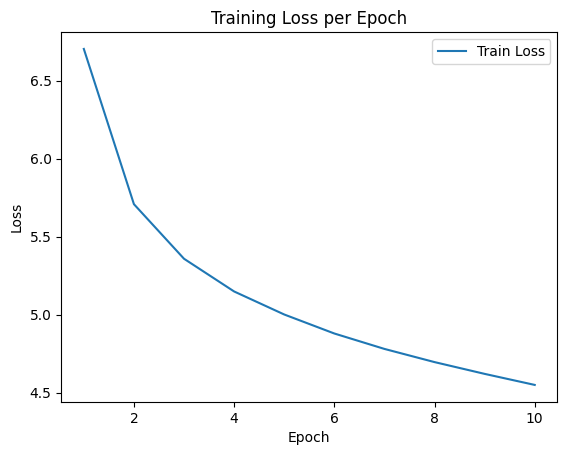

In [28]:
# Plot training loss
epochs = list(range(1, len(loss_vals) + 1))

plt.plot(epochs, loss_vals, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.show()

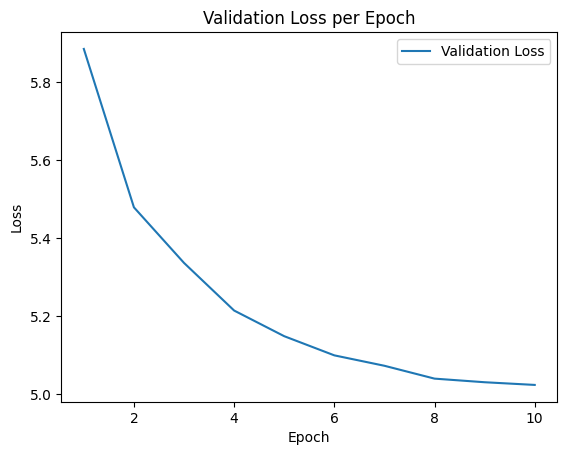

In [29]:
# Plot validation loss
epochs = list(range(1, len(val_loss_vals) + 1))

plt.plot(epochs, val_loss_vals, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss per Epoch")
plt.legend()
plt.show()

(12, 5)


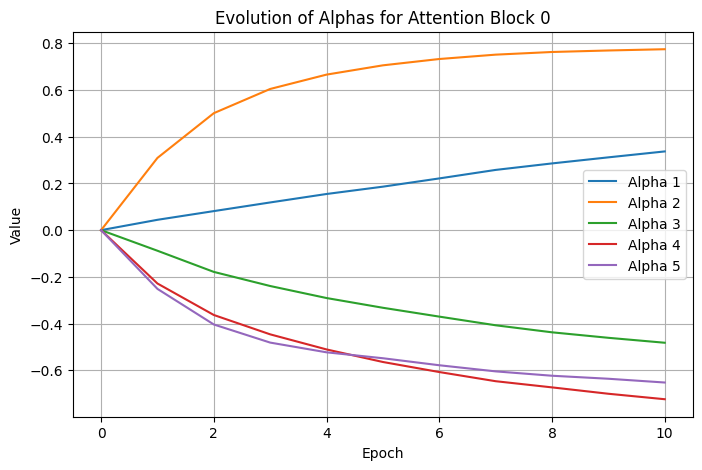

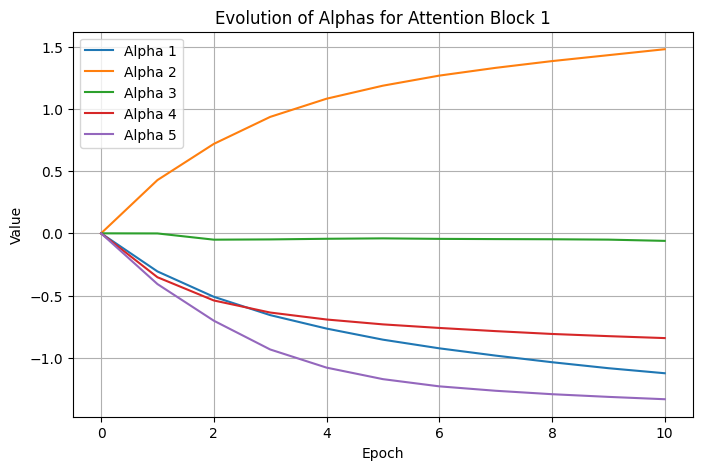

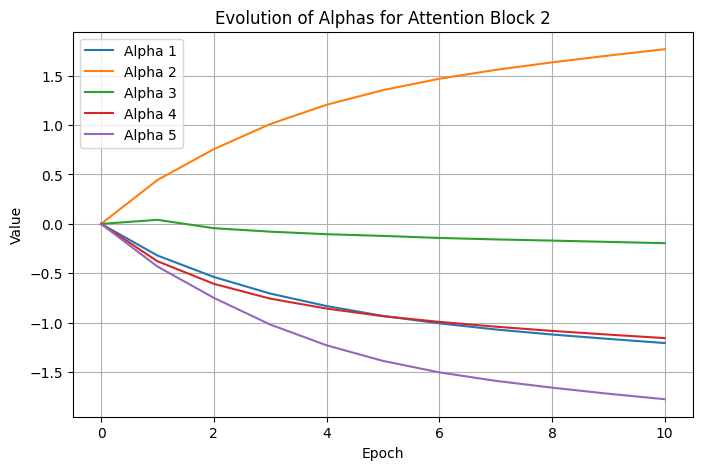

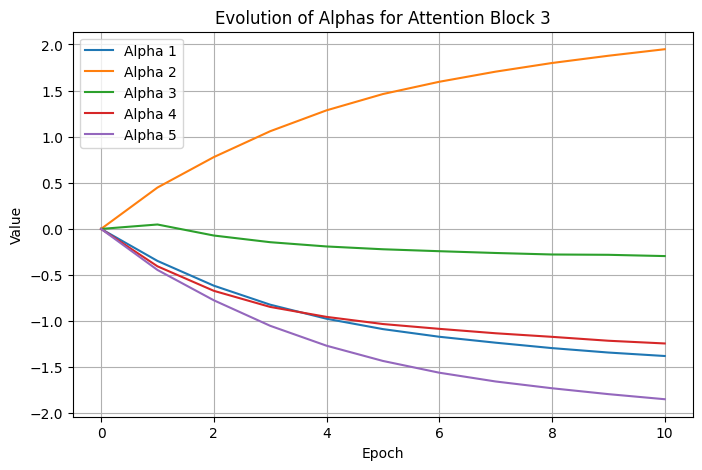

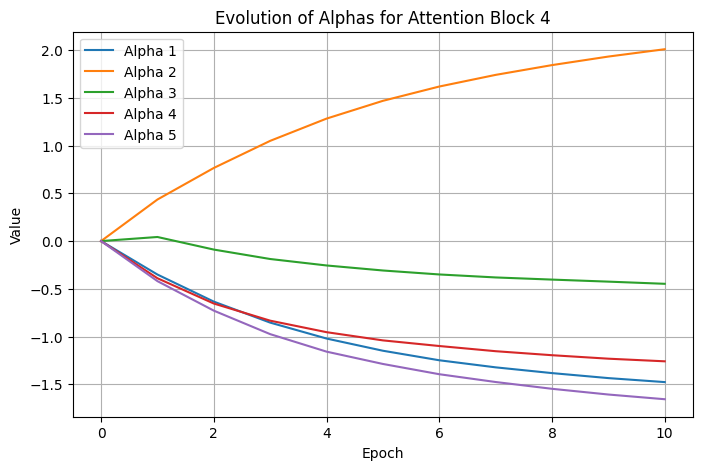

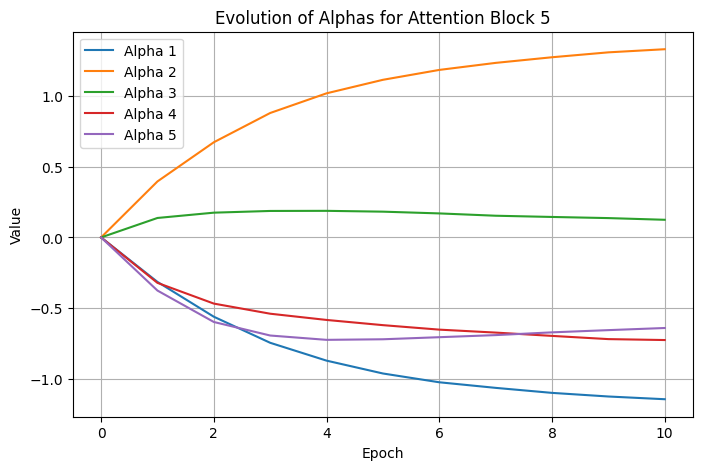

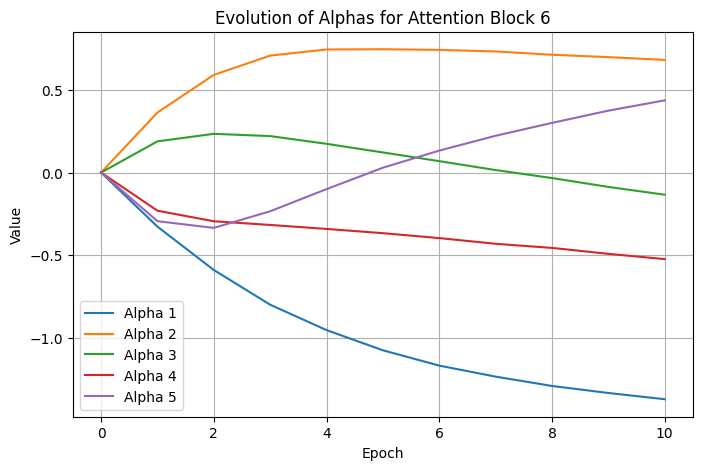

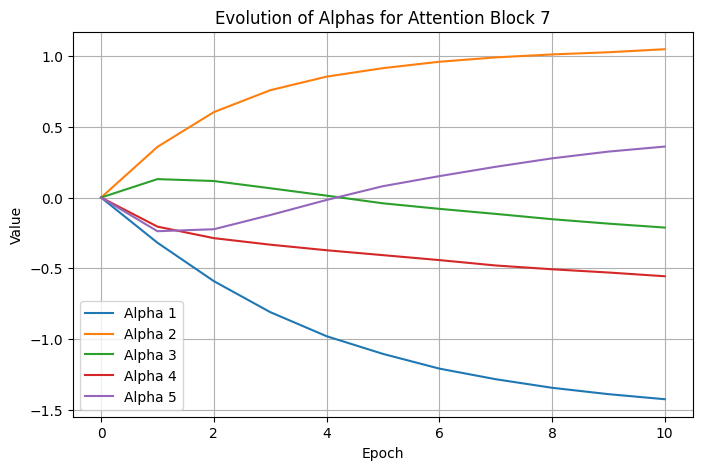

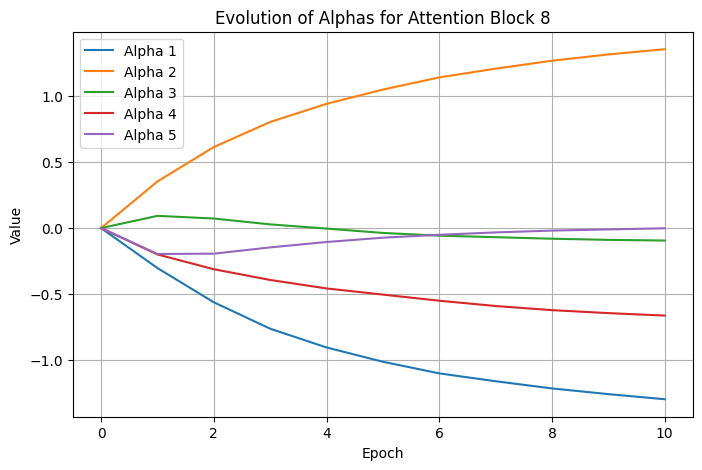

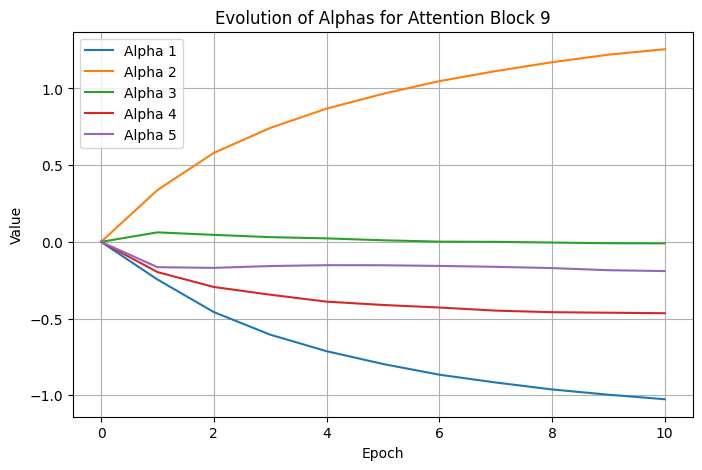

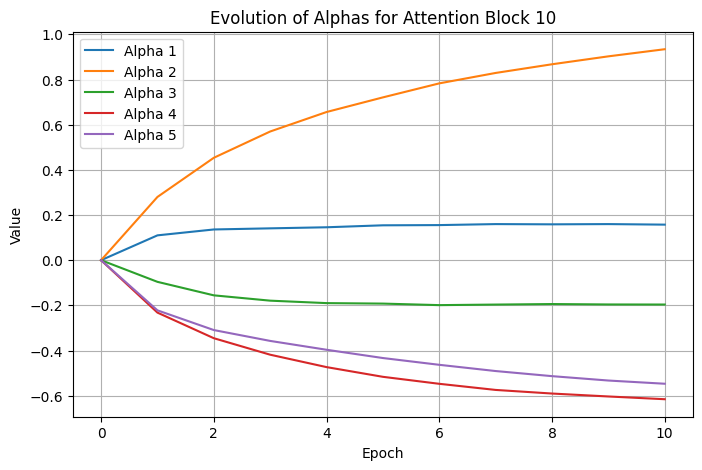

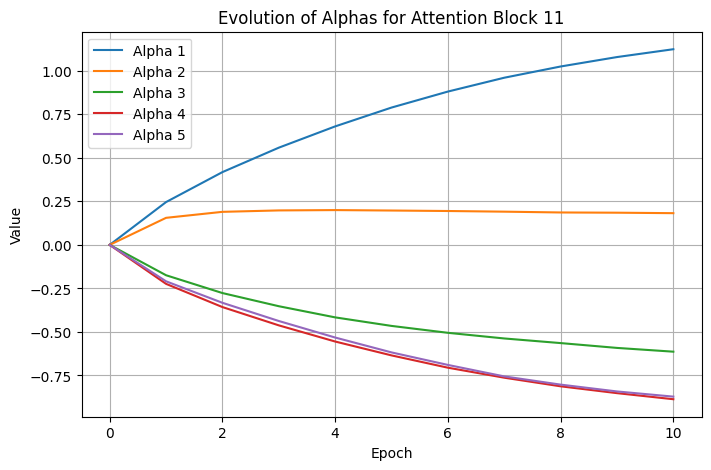

In [30]:
# Plot alphas
print(all_alphas[0].shape)
for row_idx in range(all_alphas[0].shape[0]):
    plt.figure(figsize=(8, 5))

    time_series = np.array([matrix[row_idx] for matrix in all_alphas])

    for col_idx in range(all_alphas[0].shape[1]):
        plt.plot(time_series[:, col_idx], label=f'Alpha {col_idx + 1}')

    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'Evolution of Alphas for Attention Block {row_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
# For mask verification using extracted alphas
def compute_current_mask(module: CustomLearnableAttention,
                         seq_length: int,
                         batch_size: int = 1) -> torch.Tensor:
    device = module.alpha.device

    # 1) regenerate the candidate_masks for this length
    candidate_masks = CustomLearnableAttention.get_candidate_masks(seq_length, device)  # (C, L, L)

    # 2) get the learned weights
    w = torch.sigmoid(module.alpha)               # (C,)
    w = w.view(module.num_candidates, 1, 1)       # (C,1,1)

    # 3) weighted sum → (L, L)
    final2d = (candidate_masks * w).sum(dim=0)    # (L, L)

    # 4) expand over batch & heads → (B, H, L, L)
    return final2d.unsqueeze(0).unsqueeze(0).expand(batch_size, module.num_heads, seq_length, seq_length)

def gather_all_masks(model: nn.Module,
                     seq_length: int,
                     batch_size: int = 1) -> torch.Tensor:
    masks = []
    for module in model.modules():
        if isinstance(module, CustomLearnableAttention):
            # recompute the batched mask: (B, H, L, L)
            mask_batched = compute_current_mask(module, seq_length, batch_size)
            # take the first example in batch → (H, L, L)
            masks.append(mask_batched[0])
    # stack along a new "block" dimension → (blocks, H, L, L)
    return torch.stack(masks, dim=0)

Final alphas:
tensor([[ 3.3718e-01,  7.7491e-01, -4.8220e-01, -7.2409e-01, -6.5254e-01],
        [-1.1245e+00,  1.4797e+00, -6.0621e-02, -8.4200e-01, -1.3333e+00],
        [-1.2041e+00,  1.7657e+00, -1.9503e-01, -1.1542e+00, -1.7719e+00],
        [-1.3780e+00,  1.9484e+00, -2.9453e-01, -1.2420e+00, -1.8466e+00],
        [-1.4762e+00,  2.0080e+00, -4.4733e-01, -1.2586e+00, -1.6554e+00],
        [-1.1462e+00,  1.3333e+00,  1.2504e-01, -7.2692e-01, -6.4166e-01],
        [-1.3709e+00,  6.8109e-01, -1.3410e-01, -5.2361e-01,  4.3646e-01],
        [-1.4273e+00,  1.0496e+00, -2.1256e-01, -5.5701e-01,  3.6066e-01],
        [-1.2983e+00,  1.3568e+00, -9.4681e-02, -6.6381e-01, -1.5306e-03],
        [-1.0260e+00,  1.2559e+00, -9.9070e-03, -4.6532e-01, -1.9060e-01],
        [ 1.5747e-01,  9.3424e-01, -1.9634e-01, -6.1564e-01, -5.4707e-01],
        [ 1.1240e+00,  1.8217e-01, -6.1352e-01, -8.8662e-01, -8.7170e-01]])

----- Mask Visualizations -----
Block: 0
Scaled alphas: tensor([0.5835, 0.6846, 0.38

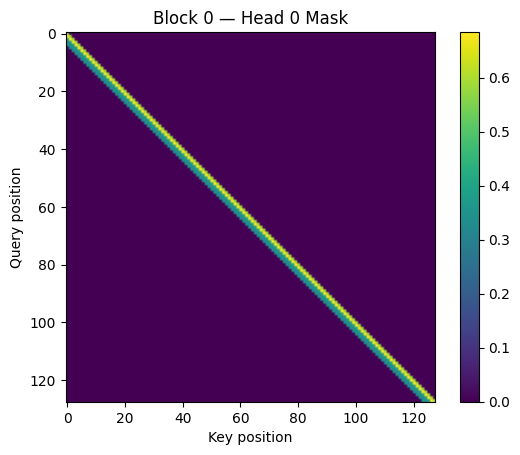

Block: 1
Scaled alphas: tensor([0.2452, 0.8145, 0.4848, 0.3011, 0.2086])


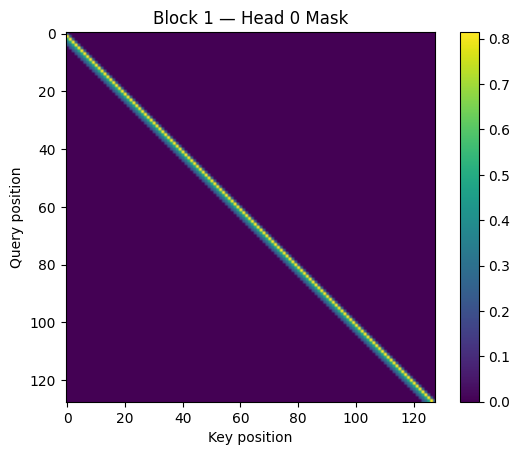

Block: 2
Scaled alphas: tensor([0.2307, 0.8539, 0.4514, 0.2397, 0.1453])


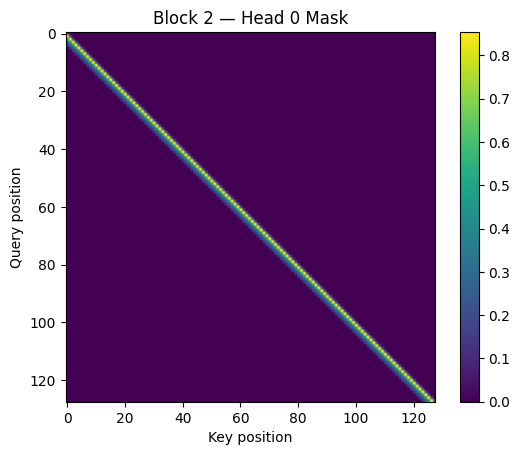

Block: 3
Scaled alphas: tensor([0.2013, 0.8753, 0.4269, 0.2241, 0.1363])


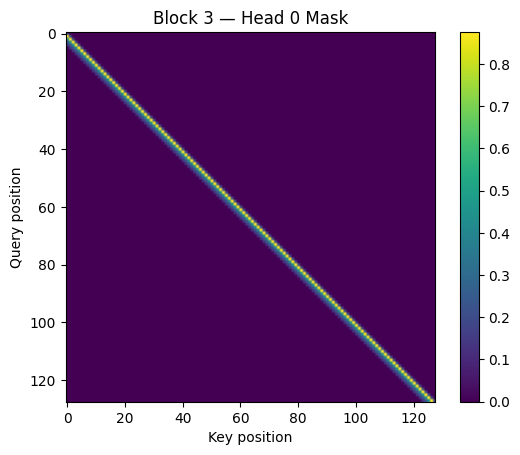

Block: 4
Scaled alphas: tensor([0.1860, 0.8816, 0.3900, 0.2212, 0.1604])


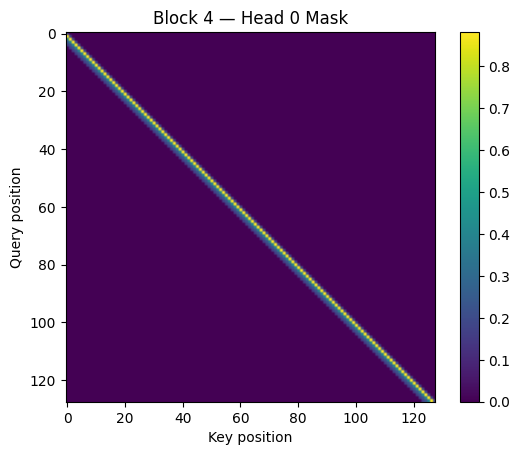

Block: 5
Scaled alphas: tensor([0.2412, 0.7914, 0.5312, 0.3259, 0.3449])


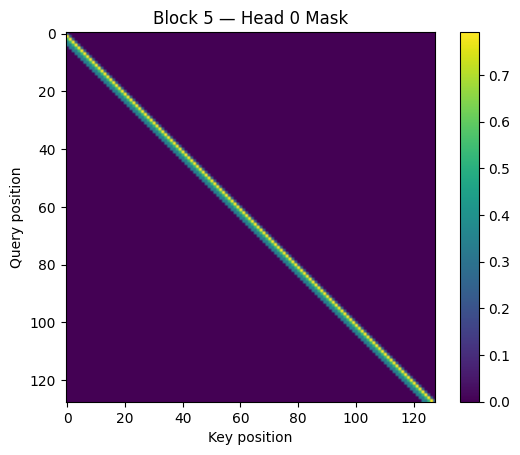

Block: 6
Scaled alphas: tensor([0.2025, 0.6640, 0.4665, 0.3720, 0.6074])


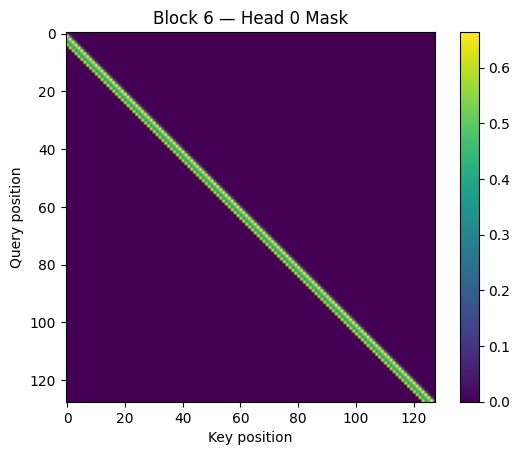

Block: 7
Scaled alphas: tensor([0.1935, 0.7407, 0.4471, 0.3642, 0.5892])


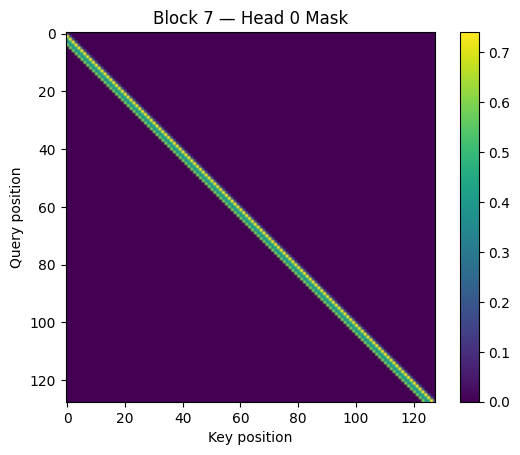

Block: 8
Scaled alphas: tensor([0.2144, 0.7952, 0.4763, 0.3399, 0.4996])


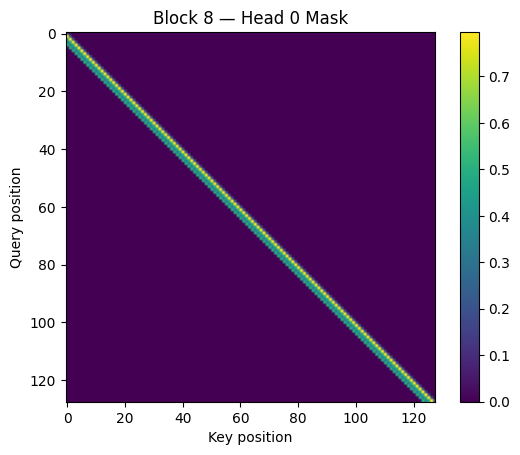

Block: 9
Scaled alphas: tensor([0.2639, 0.7783, 0.4975, 0.3857, 0.4525])


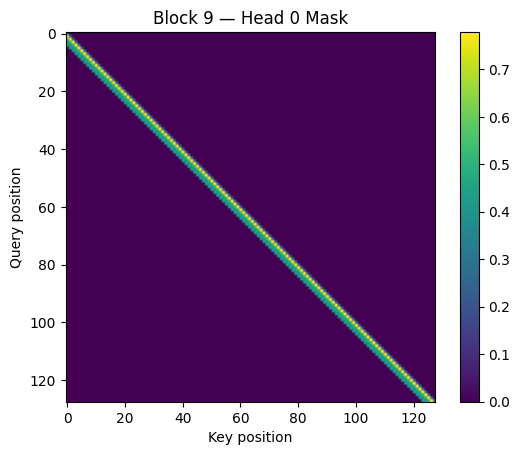

Block: 10
Scaled alphas: tensor([0.5393, 0.7179, 0.4511, 0.3508, 0.3665])


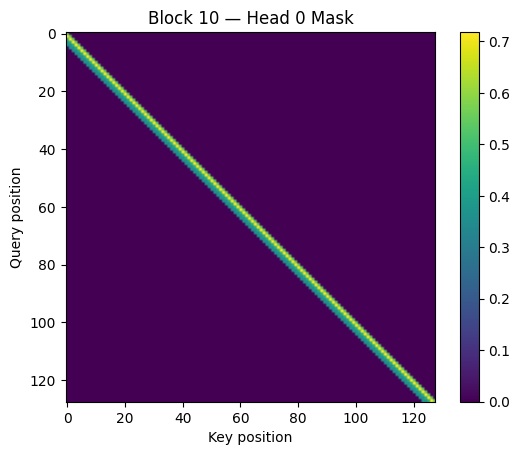

Block: 11
Scaled alphas: tensor([0.7547, 0.5454, 0.3513, 0.2918, 0.2949])


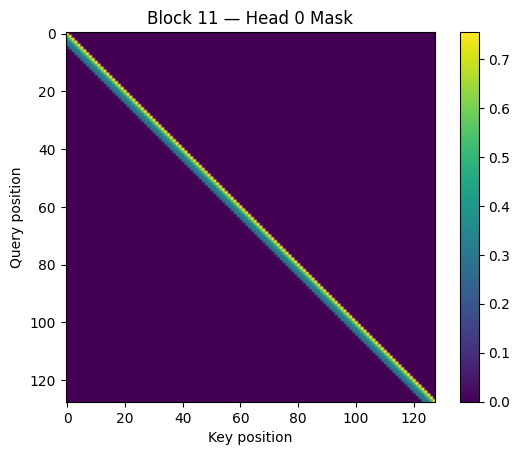


----- Zoomed in Mask Visualizations -----
Block: 4
Scaled alphas: tensor([0.1860, 0.8816, 0.3900, 0.2212, 0.1604])


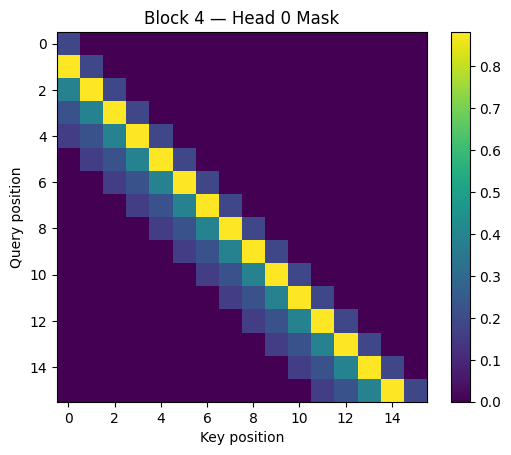

Block: 11
Scaled alphas: tensor([0.7547, 0.5454, 0.3513, 0.2918, 0.2949])


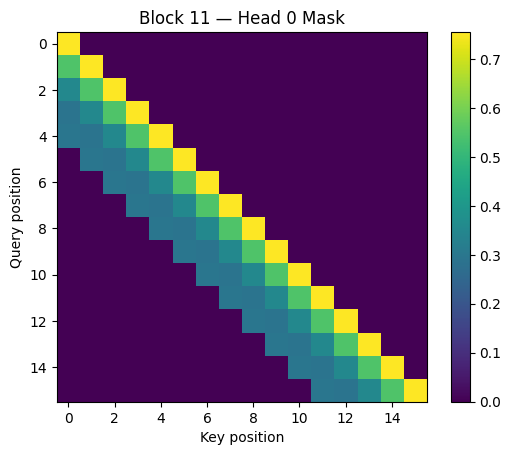

In [33]:
final_alphas = torch.from_numpy(get_alphas(custom_model))
print("Final alphas:")
print(final_alphas)
masks = gather_all_masks(custom_model, MAX_SEQ_LENGTH, BATCH_SIZE).to("cpu")
candidate_masks = CustomLearnableAttention.get_candidate_masks(MAX_SEQ_LENGTH, DEVICE, 5).to("cpu")

print("\n----- Mask Visualizations -----")

for i in range(12):
    print("Block:", i)
    first_head = masks[i, 0]
    scaled_alphas = torch.sigmoid(final_alphas[i])
    print("Scaled alphas:", scaled_alphas)

    # Verifying sum still holds
    # final_mask = torch.sum(candidate_masks * scaled_alphas[:, None, None], dim=0)
    first_head_np = first_head.detach().numpy()

    plt.figure()
    plt.imshow(first_head_np) # default colormap
    plt.title(f"Block {i} — Head 0 Mask")
    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.colorbar()
    plt.show()

print("\n----- Zoomed in Mask Visualizations -----")

blocks_of_interest = [4, 11]
for i in blocks_of_interest:
    print("Block:", i)
    first_head = masks[i, 0]
    scaled_alphas = torch.sigmoid(final_alphas[i])
    print("Scaled alphas:", scaled_alphas)

    # Verifying sum still holds
    # final_mask = torch.sum(candidate_masks * scaled_alphas[:, None, None], dim=0)
    small_head = first_head[:16, :16].detach().numpy()

    plt.figure()
    plt.imshow(small_head) # default colormap
    plt.title(f"Block {i} — Head 0 Mask")
    plt.xlabel("Key position")
    plt.ylabel("Query position")
    plt.colorbar()
    plt.show()

In [34]:
# ------------------------------
# Text Generation Comparison
# ------------------------------

def generate_text(model, prompt, max_length=50, temperature=0.7, top_k=50, tracker=None):
    """
    Generate text using the provided model and prompt.
    Note: We disable caching (use_cache=False) for our custom model.
    """
    if tracker is not None:
        tracker.start_tracking()

    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        sequences = model.generate(
            inputs.input_ids,
            max_length=max_length,
            do_sample=True,
            temperature=temperature,
            top_k=top_k,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.2,
            no_repeat_ngram_size=2,
            use_cache=False  # Disable caching for compatibility with custom attention
        )

    seq_len = sequences.size(1)
    output = tokenizer.decode(sequences[0], skip_special_tokens=True)

    if tracker is not None:
        tracker.stop_tracking(is_training=False, max_token_length=seq_len)

    return output

In [35]:
ref_tracker = UsageTracker()

In [36]:
sample_prompts = [
    "Hello, my name is",
    "The meaning of life is",
    "In a shocking turn of events,",
    "The future of artificial intelligence"
]

longer_sample_prompts = [
    "As the sun set behind the towering mountains, the weary traveler finally caught sight of the distant village, its warm lights flickering like tiny stars",
    "In the year 2157, humanity had finally perfected interstellar travel. The first colony ship, brimming with hope and thousands of eager settlers",
    "The scientist stared at the glowing vial on the laboratory table, her fingers trembling with anticipation. After years of relentless experimentation",
    "The detective pushed open the heavy oak door, stepping into a room thick with the scent of old books and something more sinister—fear"
]

for prompt in sample_prompts + longer_sample_prompts:
    print()
    for i in range(30 if prompt in sample_prompts else 50, MAX_SEQ_LENGTH, 10):
        ref_text = generate_text(reference_model, prompt, max_length=i, tracker=ref_tracker)
        custom_text = generate_text(custom_model, prompt, max_length=i, tracker=tracker)
        print(f"Prompt:    {prompt}")
        print(f"Reference: {ref_text}")
        print(f"Custom:    {custom_text}")
        print("-" * 80)

    ref_text = generate_text(reference_model, prompt, max_length=MAX_SEQ_LENGTH, tracker=ref_tracker)
    custom_text = generate_text(custom_model, prompt, max_length=MAX_SEQ_LENGTH, tracker=tracker)
    print(f"Prompt:    {prompt}")
    print(f"Reference: {ref_text}")
    print(f"Custom:    {custom_text}")
    print("-" * 80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Prompt:    Hello, my name is
Reference: Hello, my name is Daniel Schuman.
It was about a year ago that I had been diagnosed with Stage 4 diabetes which means it wasn't
Custom:    Hello, my name is L. Célix and the second most popular of all languages in both Latin American . The Spanish language has had its
--------------------------------------------------------------------------------
Prompt:    Hello, my name is
Reference: Hello, my name is Richard. And I am your father's first-born son and in turn his second."
The woman was laughing loudly when she heard the words from her own mother as they
Custom:    Hello, my name is Tarek . When I was a kid , he got the idea that when we were younger.
 " ( and) they began to speak in their own voice as possible
--------------------------------------------------------------------------------
Prompt:    Hello, my name is
Reference: Hello, my name is Michael. I am a 24 year old male with dark hair and brown eyes."
"Um….You mean that you're not we

As the alphas approach -infinity, this means the masks are less and less important, and as they approach +infinity, they are more and more important. (The coefficients of the candidate masks are actually the sigmoid of the alphas.)

Custom Model Plots


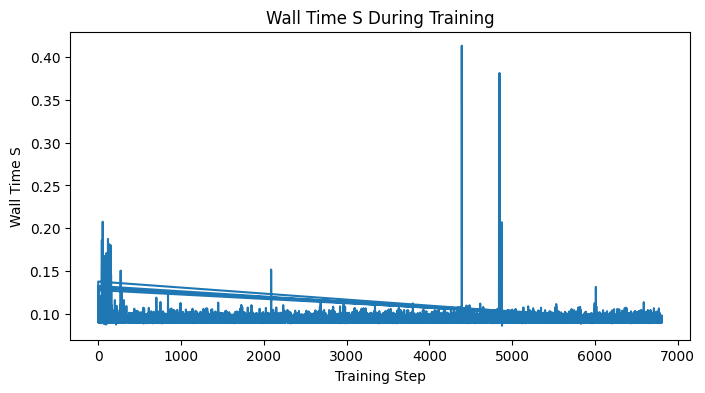

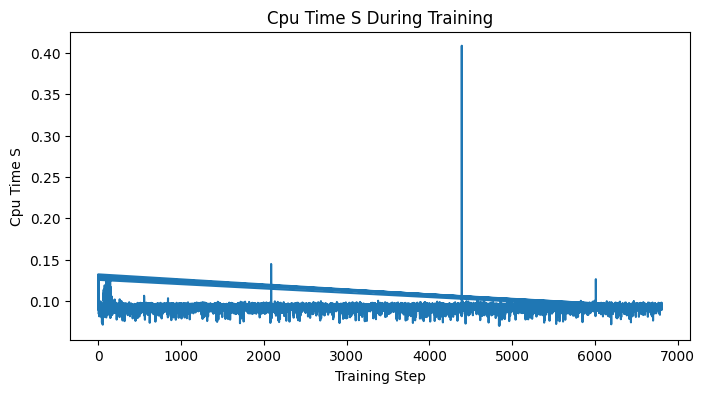

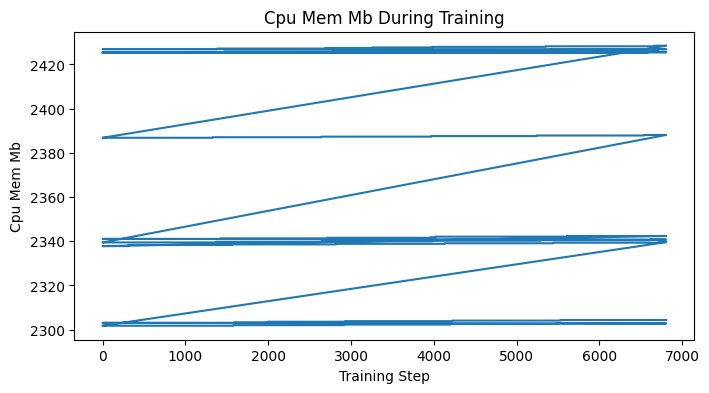

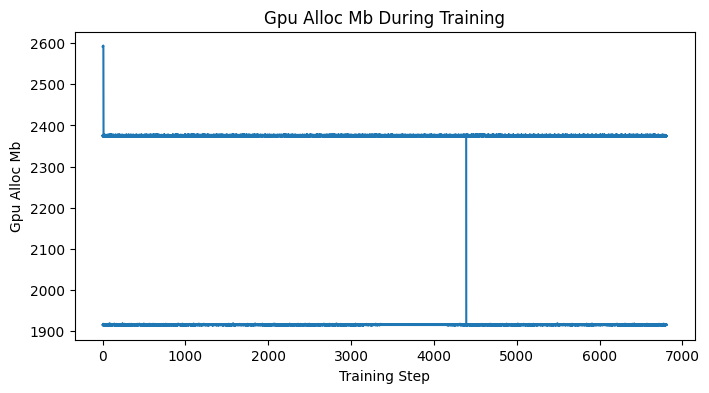

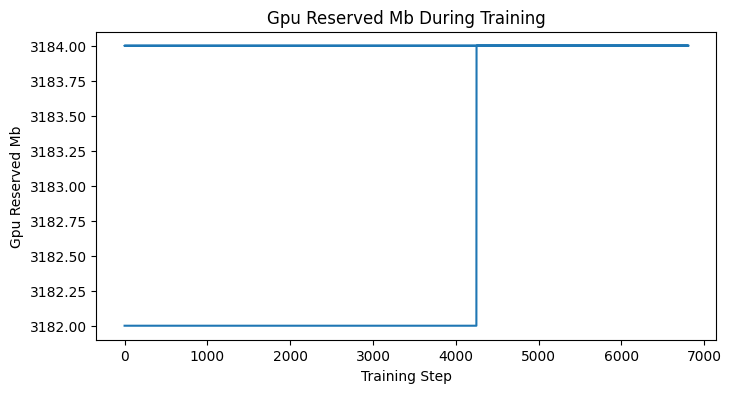

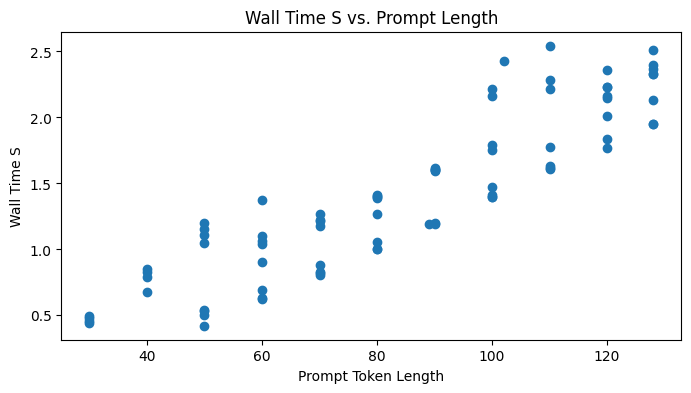

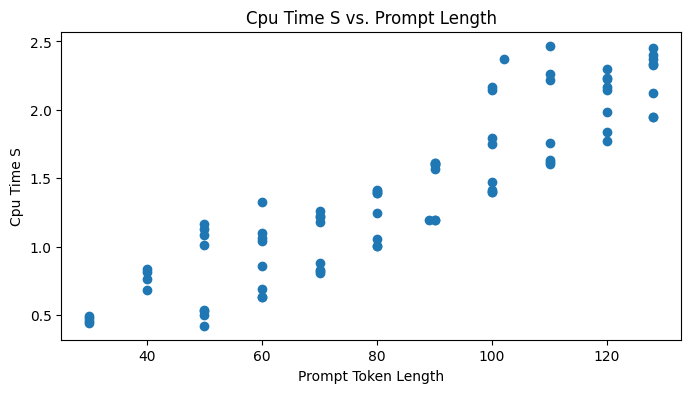

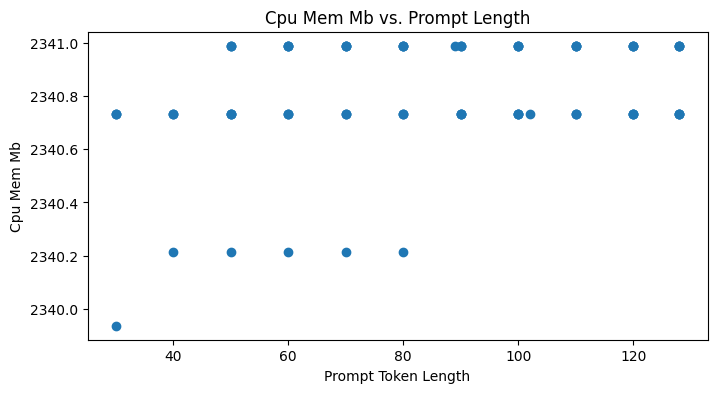

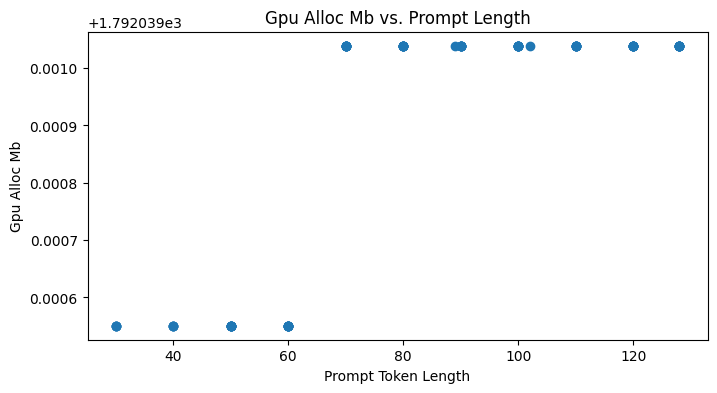

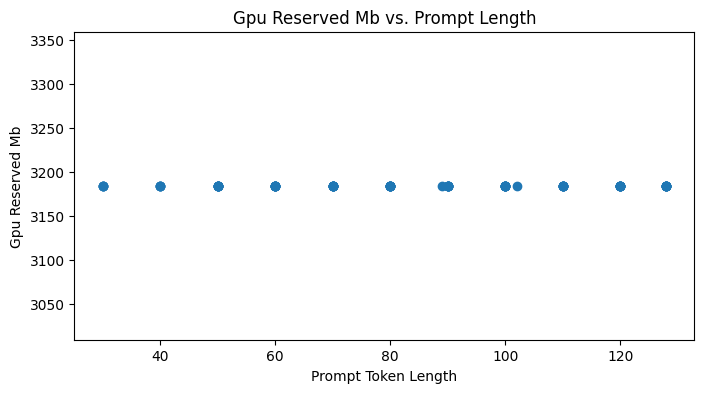

Reference Model Plots


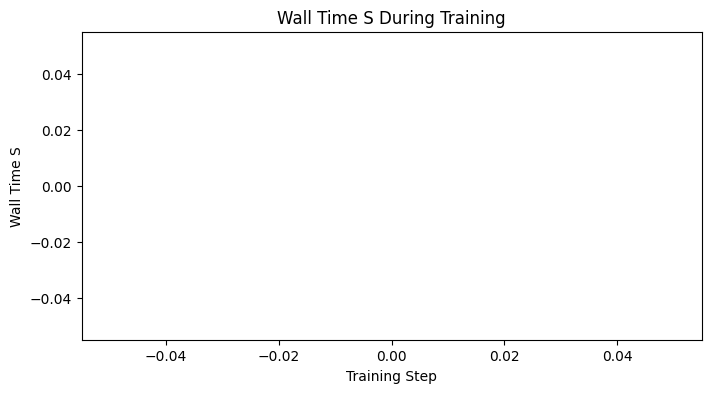

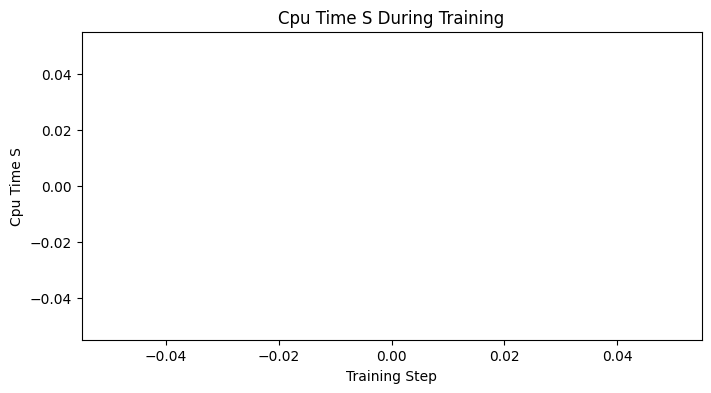

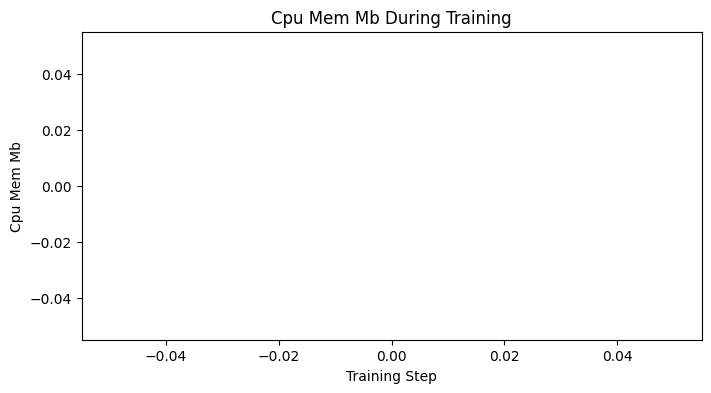

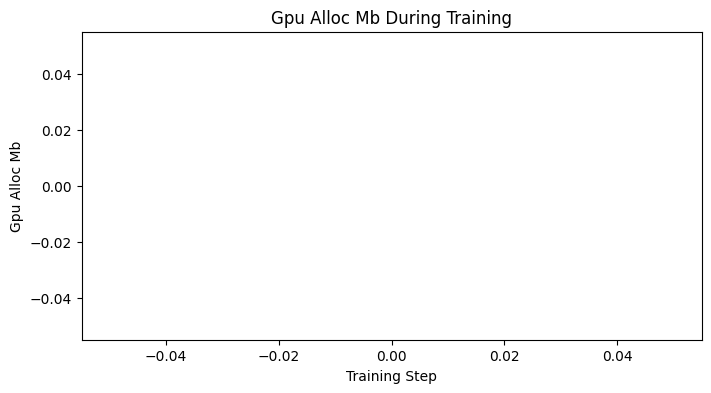

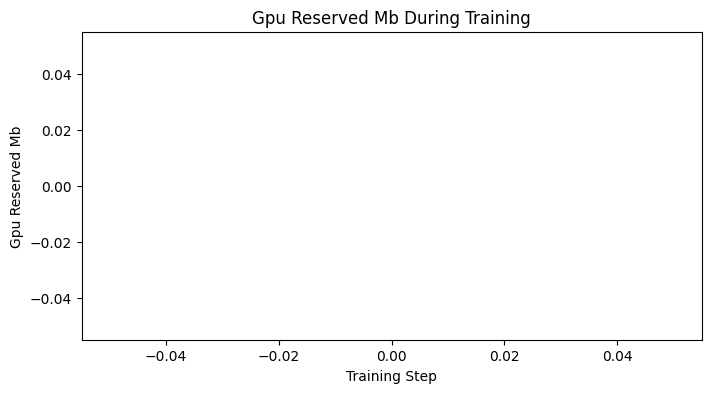

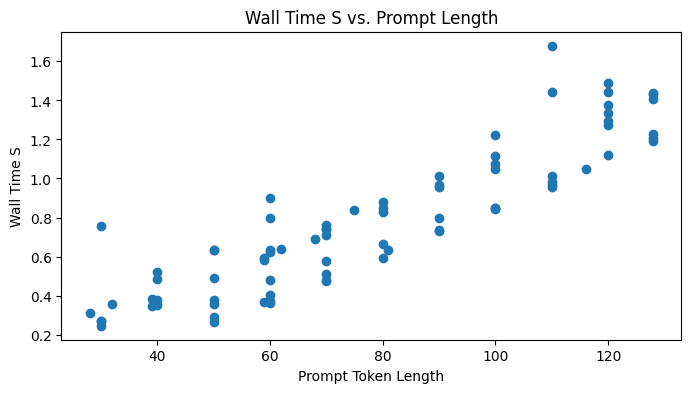

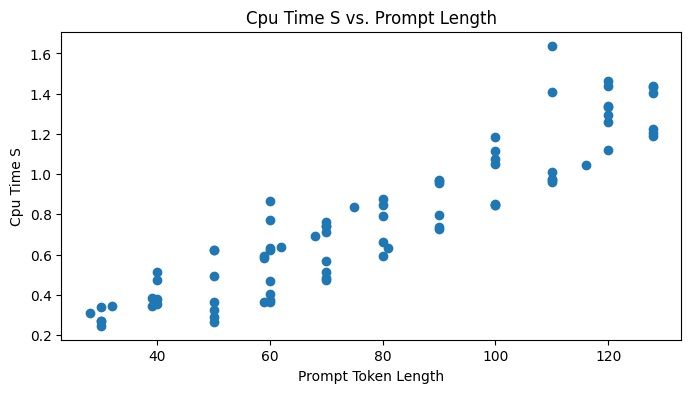

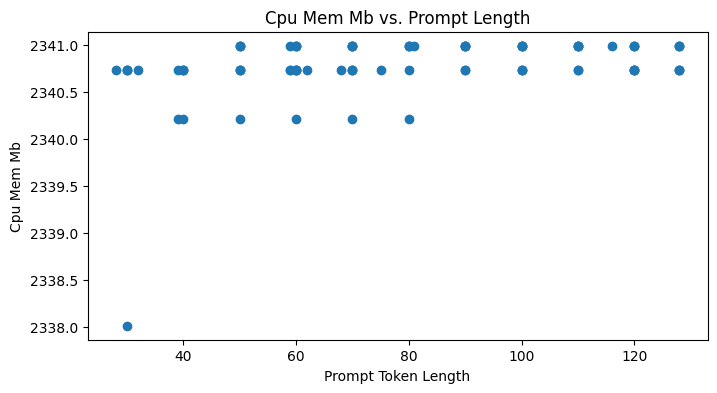

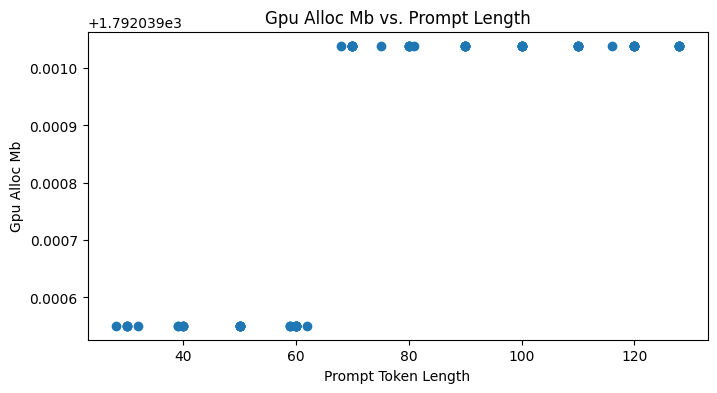

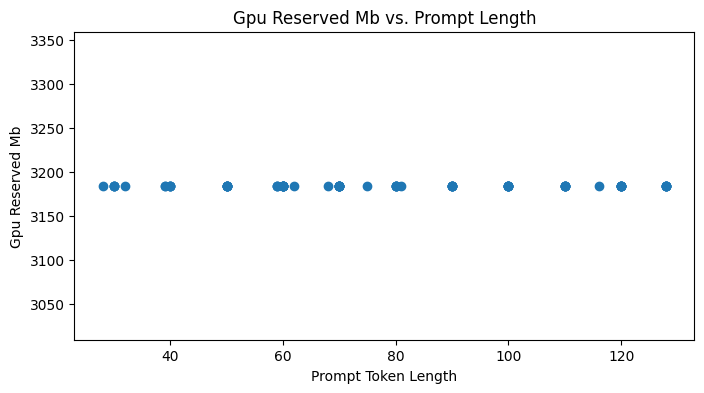

In [37]:
# Plot usage
print("Custom Model Plots")
tracker.plot()
print("Reference Model Plots")
ref_tracker.plot()

In [38]:
checkpoint = {
    'train_stats': tracker.train_stats,
    'infer_stats': tracker.infer_stats
}
torch.save(checkpoint, os.path.join(CHECKPOINT_DIR, f'tracker_epoch_{epoch+1}.pth'))
print(f"Saved tracker for epoch {epoch+1}")

Saved tracker for epoch 10
